# GTZAN Audio Classification with VGGish Model

PyTorch VGGish implementation inspired by [paper](https://arxiv.org/pdf/1609.09430)
```
The only changes we made to VGG (configuration E) [2] were to
the final layer (3087 units with a sigmoid) as well as the use of batch
normalization instead of LRN. While the original network had 144M
weights and 20B multiplies, the audio variant uses 62M weights and
2.4B multiplies. We tried another variant that reduced the initial
strides (as we did with AlexNet), but found that not modifying the
strides resulted in faster training and better performance. With our
setup, parallelizing beyond 10 GPUs did not help significantly, so
we trained with 10 GPUs and 5 parameter servers. We modified the inception V3 [3] network by removing the first four
layers of the stem, up to and including the MaxPool, as well as re-
moving the auxiliary network. We changed the Average Pool size to
10 × 6 to reflect the change in activations. We tried including the
stem and removing the first stride of 2 and MaxPool but found that it
performed worse than the variant with the truncated stem. The orig-
inal network has 27M weights with 5.6B multiplies, and the audio
variant has 28M weights and 4.7B multiplies. We trained with 40
GPUs and 20 parameter servers.
```

I'm using pre-generated Mel spectrograms from the GTZAN images_original directory

The model is originally trained on `YouTube-100M` dataset, which is much bigger than GTZAN.

PyTorch offers pretrained model, but it is based on unmaintained repository and trained on YouTube-100M dataset.

Optimized for macOS with ARM processors


In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from tqdm.notebook import tqdm
import torchvision.transforms as transforms

In [4]:
# Use MPS (for Apple Silicon) or CPU
device = torch.device("mps" if torch.backends.mps.is_available() 
                      else "cpu")

print(f"Using device: {device}")

Using device: mps


In [5]:
# Define paths and parameters
# SOURCE: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification?resource=download-directory
DATA_PATH = "./data/gtzan"
IMAGES_PATH = "./data/gtzan/images_original"
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 0.0001
NUM_CLASSES = 10

In [6]:
# Verify the dataset exists
def check_dataset():
    """Check if the dataset exists at the specified location"""
    if not os.path.exists(IMAGES_PATH):
        print(f"Error: Could not find images at {IMAGES_PATH}")
        print("Please make sure the path is correct and the dataset is downloaded.")
        return False
    
    # Check expected genre folders
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
             'jazz', 'metal', 'pop', 'reggae', 'rock']
    
    missing_genres = []
    for genre in genres:
        genre_path = os.path.join(IMAGES_PATH, genre)
        if not os.path.exists(genre_path):
            missing_genres.append(genre)
    
    if missing_genres:
        print(f"Missing genre folders: {missing_genres}")
        return False
    
    print("Dataset verified successfully!")
    return True

if not check_dataset():
    raise Exception("Dataset verification failed. Please check the paths and dataset structure.")

Dataset verified successfully!


In [7]:
# Define image transformations for normalization and augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match VGG input size
    transforms.RandomHorizontalFlip(p=0.5),  # Data augmentation - is this needed?
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # maybe smaller?
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Create custom dataset for GTZAN mel spectrogram images
class GTZANImageDataset(Dataset):
    """Custom dataset for GTZAN using pre-generated mel spectrogram images"""
    def __init__(self, images_path, transform=None, split='train'):
        self.images_path = images_path
        self.transform = transform
        self.split = split
        
        self.genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
                     'jazz', 'metal', 'pop', 'reggae', 'rock']
        
        self.label_map = {genre: i for i, genre in enumerate(self.genres)}
        
        self.files = []
        self.labels = []
        
        for genre in self.genres:
            genre_path = os.path.join(images_path, genre)
            if os.path.exists(genre_path):
                for filename in os.listdir(genre_path):
                    if filename.endswith('.png') or filename.endswith('.jpg'):
                        self.files.append(os.path.join(genre_path, filename))
                        self.labels.append(self.label_map[genre])
        
        # Train/val set
        if split != 'all':
            train_files, val_files, train_labels, val_labels = train_test_split(
                self.files, self.labels, test_size=0.2, stratify=self.labels, random_state=42
            )
            
            if split == 'train':
                self.files = train_files
                self.labels = train_labels
            else:
                self.files = val_files
                self.labels = val_labels
        
        print(f"Loaded {len(self.files)} images for {split} split")
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]
       
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [9]:
# Define the VGGish model optimized for spectrogram images
# VGGNet 16: https://medium.com/@siddheshb008/vgg-net-architecture-explained-71179310050f
class VGGish(nn.Module):
    """VGGish model architecture adapted for GTZAN classification"""
    def __init__(self, num_classes=10):
        super(VGGish, self).__init__()
        
        # Input: Mel spectrogram images (3, 224, 224) # RGB images, maybe just grayscale(1, 224, 224)?
        
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
        
        self.dropout = nn.Dropout(0.5)
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv1_1(x))
        x = self.relu(self.conv1_2(x))
        x = self.pool1(x)
        
        x = self.relu(self.conv2_1(x))
        x = self.relu(self.conv2_2(x))
        x = self.pool2(x)
        
        x = self.relu(self.conv3_1(x))
        x = self.relu(self.conv3_2(x))
        x = self.relu(self.conv3_3(x))
        x = self.pool3(x)
        
        x = self.relu(self.conv4_1(x))
        x = self.relu(self.conv4_2(x))
        x = self.relu(self.conv4_3(x))
        x = self.pool4(x)
        
        x = self.relu(self.conv5_1(x))
        x = self.relu(self.conv5_2(x))
        x = self.relu(self.conv5_3(x))
        x = self.pool5(x)
        
        x = x.view(x.size(0), -1)   # Flatten
        
        # Dense * 3?
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [10]:
train_dataset = GTZANImageDataset(IMAGES_PATH, transform=train_transforms, split='train')
val_dataset = GTZANImageDataset(IMAGES_PATH, transform=val_transforms, split='val')

# It doesn't work with num_workers > 0 on MPS, at least for me
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = VGGish(num_classes=NUM_CLASSES).to(device)

# class_weights = torch.ones(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()#(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

Loaded 799 images for train split
Loaded 200 images for val split


Image batch shape: torch.Size([32, 3, 224, 224])
Label distribution: [4, 2, 5, 4, 4, 2, 5, 2, 2, 2]


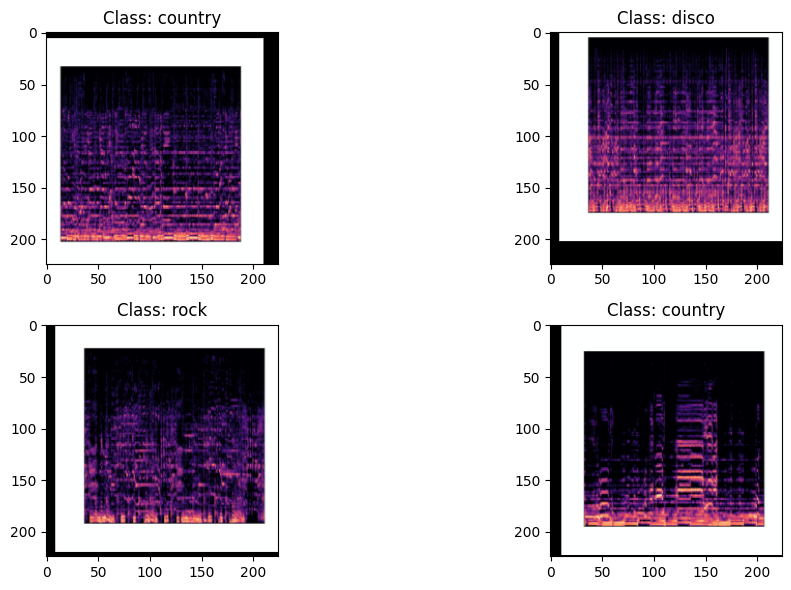

In [ ]:
def verify_data_loading():
    images, labels = next(iter(train_loader))
    print(f"Image batch shape: {images.shape}")
    print(f"Label distribution: {[labels.tolist().count(i) for i in range(NUM_CLASSES)]}")
    
    # Visualize some images for vibe check :)
    plt.figure(figsize=(12, 6))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"Class: {train_dataset.genres[labels[i]]}")
    plt.tight_layout()
    plt.show()


verify_data_loading()
# NOTE: Maybe augmentation breaks the model, due to white padding and transforms?

In [ ]:
# For debugging
def check_predictions_distribution():
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(val_loader))
        images = images.to(device)
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)
        
        pred_dist = [predictions.cpu().tolist().count(i) for i in range(NUM_CLASSES)]
        print(f"Prediction distribution: {pred_dist}")
        
        softmax_outputs = F.softmax(outputs, dim=1)
        print(f"Average softmax confidence: {softmax_outputs.max(dim=1)[0].mean().item()}")
        print(f"Min softmax range per sample: {(softmax_outputs.max(dim=1)[0] - softmax_outputs.min(dim=1)[0]).min().item()}")

# Training and validation functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels


In [14]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    """Train the model for specified number of epochs"""
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_loss = float('inf')
    best_model_weights = None
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        check_predictions_distribution()
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, device)
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc
            }, 'best_vggish_model.pth')
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
    
    model.load_state_dict(best_model_weights)
    
    return model, history



In [ ]:
# Train the model
model, history = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    scheduler, 
    NUM_EPOCHS, 
    device
)

Epoch 1/20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.5594, Train Acc: 0.0751
Val Loss: 2.3030, Val Acc: 0.1000
Epoch 2/20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3045, Train Acc: 0.0876
Val Loss: 2.3028, Val Acc: 0.1000
Epoch 3/20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3045, Train Acc: 0.0864
Val Loss: 2.3026, Val Acc: 0.1000
Epoch 4/20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3036, Train Acc: 0.0889
Val Loss: 2.3027, Val Acc: 0.1000
Epoch 5/20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3035, Train Acc: 0.0901
Val Loss: 2.3027, Val Acc: 0.1000
Epoch 6/20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3037, Train Acc: 0.0751
Val Loss: 2.3026, Val Acc: 0.1000
Epoch 7/20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3033, Train Acc: 0.0839
Val Loss: 2.3026, Val Acc: 0.1000
Epoch 8/20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3032, Train Acc: 0.0826
Val Loss: 2.3026, Val Acc: 0.1000
Epoch 9/20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3030, Train Acc: 0.0851
Val Loss: 2.3026, Val Acc: 0.1000
Epoch 10/20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3032, Train Acc: 0.0763
Val Loss: 2.3026, Val Acc: 0.1000
Epoch 11/20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3029, Train Acc: 0.1014
Val Loss: 2.3026, Val Acc: 0.1000
Epoch 12/20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3029, Train Acc: 0.0864
Val Loss: 2.3026, Val Acc: 0.1000
Epoch 13/20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3028, Train Acc: 0.0939
Val Loss: 2.3026, Val Acc: 0.1000
Epoch 14/20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3029, Train Acc: 0.0826
Val Loss: 2.3026, Val Acc: 0.1000
Epoch 15/20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3027, Train Acc: 0.0964
Val Loss: 2.3026, Val Acc: 0.1000
Epoch 16/20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3028, Train Acc: 0.0989
Val Loss: 2.3026, Val Acc: 0.1000
Epoch 17/20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3024, Train Acc: 0.1051
Val Loss: 2.3026, Val Acc: 0.1000
Epoch 18/20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3026, Train Acc: 0.1089
Val Loss: 2.3026, Val Acc: 0.1000
Epoch 19/20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3028, Train Acc: 0.0939
Val Loss: 2.3026, Val Acc: 0.1000
Epoch 20/20


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3029, Train Acc: 0.0914
Val Loss: 2.3026, Val Acc: 0.1000


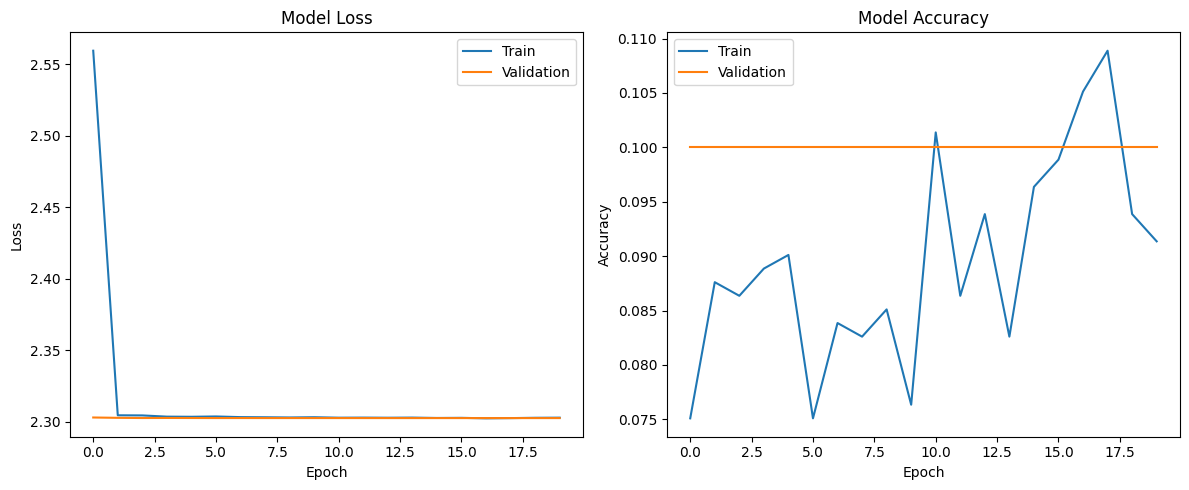

In [ ]:


# Visualize training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Validating:   0%|          | 0/7 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

       blues     0.1000    1.0000    0.1818        20
   classical     0.0000    0.0000    0.0000        20
     country     0.0000    0.0000    0.0000        20
       disco     0.0000    0.0000    0.0000        20
      hiphop     0.0000    0.0000    0.0000        20
        jazz     0.0000    0.0000    0.0000        20
       metal     0.0000    0.0000    0.0000        20
         pop     0.0000    0.0000    0.0000        20
      reggae     0.0000    0.0000    0.0000        20
        rock     0.0000    0.0000    0.0000        20

    accuracy                         0.1000       200
   macro avg     0.0100    0.1000    0.0182       200
weighted avg     0.0100    0.1000    0.0182       200



/Users/jan/git/wimu/AudioConcept/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jan/git/wimu/AudioConcept/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jan/git/wimu/AudioConcept/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

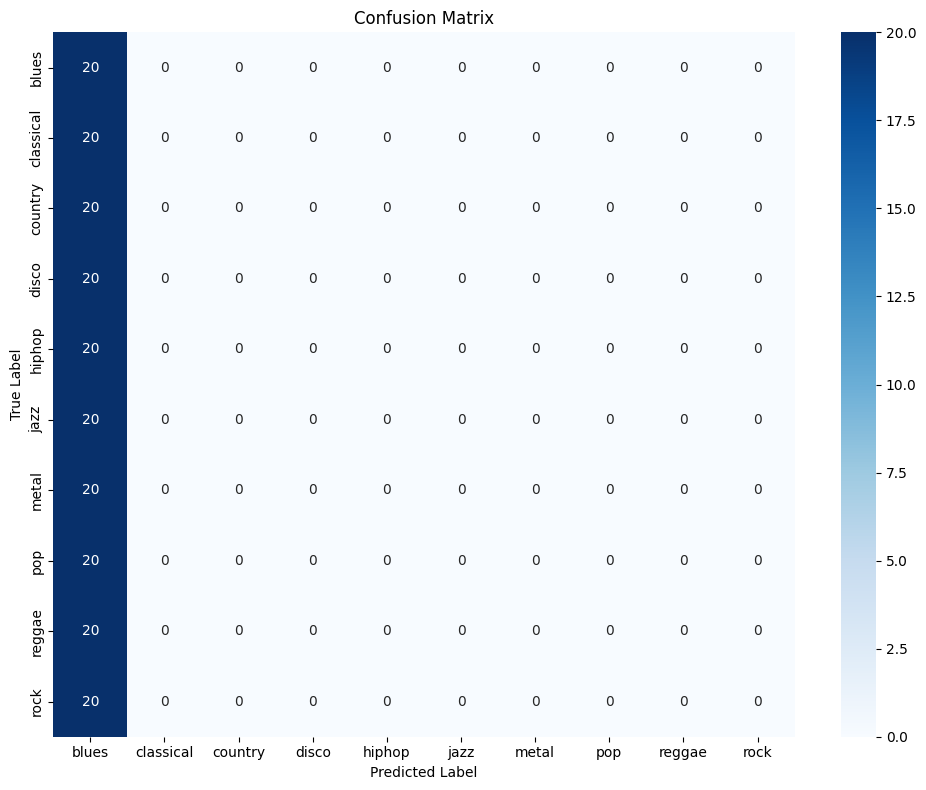

In [ ]:
# Evaluate the model on validation set
val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, device)

print("\nClassification Report:")
print(classification_report(
    val_labels, 
    val_preds, 
    target_names=train_dataset.genres,
    digits=4
))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(val_labels, val_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.genres,
            yticklabels=train_dataset.genres)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [ ]:


torch.save({
    'model_state_dict': model.state_dict(),
}, 'vggish_gtzan_final_001.pth')


Predicted genre for test file (blues/blues00009.png): blues


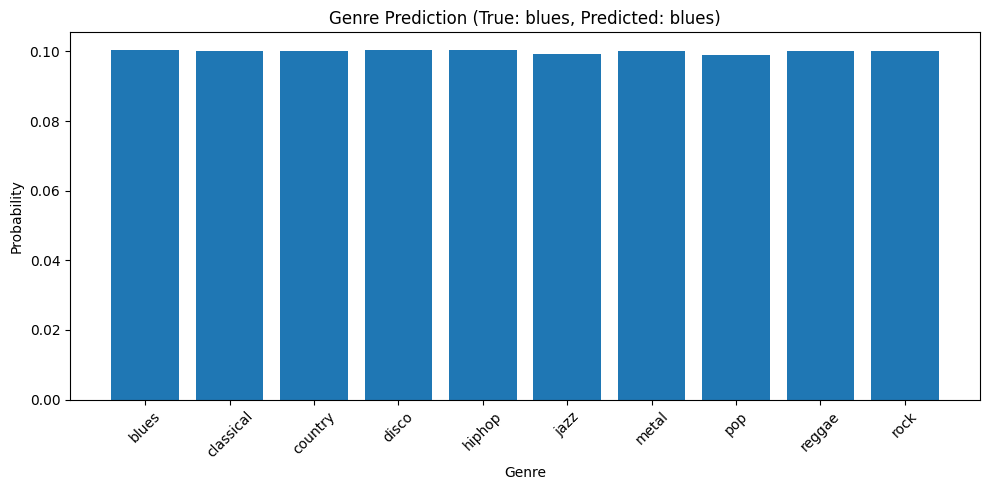

In [ ]:
# I dont know if that works or not
def predict_genre(image_path, model, transform, device, genres):
    """Predict genre for a single spectrogram image"""
    model.eval()
    
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    predicted_genre = genres[predicted.item()]
    probs = probabilities.cpu().numpy()[0]
    
    return predicted_genre, probs

sample_genres = train_dataset.genres
for genre in sample_genres:
    genre_path = os.path.join(IMAGES_PATH, genre)
    if os.path.exists(genre_path):
        sample_files = os.listdir(genre_path)
        if sample_files:
            test_file = os.path.join(genre_path, sample_files[0])
            if os.path.exists(test_file):
                pred_genre, probs = predict_genre(test_file, model, val_transforms, device, train_dataset.genres)
                print(f"\nPredicted genre for test file ({genre}/{sample_files[0]}): {pred_genre}")

                plt.figure(figsize=(10, 5))
                plt.bar(train_dataset.genres, probs)
                plt.title(f'Genre Prediction (True: {genre}, Predicted: {pred_genre})')
                plt.xlabel('Genre')
                plt.ylabel('Probability')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
                break
        break